# Notebook to layout the key figures that break down the Z-dependent SFRD into it's key components

Made on Feb 7 2022, to help David with his SFRD, but also for future purposes to explore the different aspects of my SFRD


In [135]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import seaborn as sns

import h5py as h5
from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const
from scipy.stats import norm as NormDist

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

import sys
# Import functions
##############################
sys.path.insert(0,'/Users/lieke/Documents/NewCOMPAS/COMPAS/utils/PythonScripts/CosmicIntegration/')
import FastCosmicIntegration as COMPAS_sfrd
import ClassCOMPAS as COMPAS_class

from importlib import reload  # Python 3.4+
reload(COMPAS_sfrd)
##############################


######################################
## locations
proj_dir    = '/Users/lieke/surfdrive/Documents/SFRD_effects/'
save_loc    = proj_dir + 'plots/'
# By default, I use the data from  van Son + 2021 (on redshift evol of BBH merger rate)
data_dir    = '/Users/lieke/surfdrive/Documents/RedshiftEvolution_BBHMergers_WeightyMatter/output/'# 


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# Let's load our simulations 

In [90]:
#########################################
# Chirp mass
#########################################
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
   

#########################################
# Read data
#########################################
def read_data(loc = '/output/COMPAS_Output_wWeights.h5', rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned', read_SFRD = True, verbose=False):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            loc                  --> [string] Location of data
            rate_key             --> [string] group key name of COMPAS HDF5 data that contains your merger rate
            verbose              --> [bool] If you want to print statements while reading in 

        Returns:
            crude_rate_density   --> [2D float array] Intrinsic merger rate density for each binary at new crude redshiftbins in 1/yr/Gpc^3

    """
    dcokey,  syskey, CEcount, dcomask = 'DoubleCompactObjects', 'SystemParameters', 'CE_Event_Count', 'DCOmask' 
#     dcokey,  syskey, CEcount, dcomask = 'BSE_Double_Compact_Objects', 'BSE_System_Parameters', 'CE_Event_Counter', 'DCOmask'
    
    if verbose: print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    if verbose: print(File.keys(), File[rate_key].keys())
         
    ################################################
    ## Essential data for this plot
    ## Open hdf5 file and read relevant columns
    File        = h5.File(loc ,'r')

    SYS = Table()
    SYS['SEED']                  = File[syskey]['SEED'][()] 
    SYS['Mass@ZAMS(1)']          = File[syskey]['Mass@ZAMS(1)'][()]
    SYS['Mass@ZAMS(2)']          = File[syskey]['Mass@ZAMS(2)'][()]
    SYS['Metallicity@ZAMS(1)']   = File[syskey]['Metallicity@ZAMS(1)'][()] 
    SYS['mixture_weight']        = File[syskey]['mixture_weight'][()] 
    
    
    DCO = Table()
    DCO['SEED']                  = File[dcokey]['SEED'][()] 
    DCO['Metallicity@ZAMS(1)']   = File[dcokey]['Metallicity@ZAMS(1)'][()] 

    DCO[CEcount]                 = File[dcokey][CEcount][()] 
    DCO['Mass(1)']               = File[dcokey]['Mass(1)'][()]
    DCO['Mass(2)']               = File[dcokey]['Mass(2)'][()]
    DCO['M_moreMassive']         = np.maximum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['M_lessMassive']         = np.minimum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['Mchirp']                = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])
    DCO['mixture_weight']        = File[dcokey]['mixture_weight'][()]

    DCO['Stellar_Type(1)']       = File[dcokey]['Stellar_Type(1)'][()]
    DCO['Stellar_Type(2)']       = File[dcokey]['Stellar_Type(2)'][()]
    
    DCO['Immediate_RLOF>CE']     = File[dcokey]['Immediate_RLOF>CE'][()]
    DCO['Optimistic_CE']         = File[dcokey]['Optimistic_CE'][()]
    DCO['Merges_Hubble_Time']    = File[dcokey]['Merges_Hubble_Time'][()]

    SYS_DCO_seeds_bool           = np.in1d(File[syskey]['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
    DCO['Stellar_Type@ZAMS(1)']  = File[syskey]['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]
    DCO['Mass@ZAMS(1)']          = File[syskey]['Mass@ZAMS(1)'][SYS_DCO_seeds_bool]
    DCO['Mass@ZAMS(2)']          = File[syskey]['Mass@ZAMS(2)'][SYS_DCO_seeds_bool]

    if read_SFRD:
        ################################################
        ## Read merger rate related data
        DCO_mask                  = File[rate_key][dcomask][()] # Mask from DCO to merging BBH 
        redshifts                 = File[rate_key]['redshifts'][()]
        Average_SF_mass_needed    = File[rate_key]['Average_SF_mass_needed'][()]
        intrinsic_rate_density    = File[rate_key]['merger_rate'][()]
        intrinsic_rate_density_z0 = File[rate_key]['merger_rate_z0'][()] #Rate density at z=0 for the smallest z bin in your simulation

        File.close()
        return SYS, DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0 
    else:
        return SYS, DCO
        


In [91]:
SYS, DCO = read_data(loc = data_dir + 'COMPAS_Output_wWeights.h5', read_SFRD = False, verbose=True)



Reading  /Users/lieke/surfdrive/Documents/RedshiftEvolution_BBHMergers_WeightyMatter/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['Details', 'DoubleCompactObjects', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned', 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0', 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0_zBinned', 'SystemParameters']> <KeysViewHDF5 ['Average_SF_mass_needed', 'DCOmask', 'SEED', 'merger_rate', 'merger_rate_z0', 'redshifts']>


# Calculate the average SF mass that would have been required to evolve one binary


In [92]:

def find_star_forming_mass_per_binary_sampling(m1=0.01, m2=0.08, m3=0.5, m4=200.0, a12=0.3, a23=1.3, a34=2.3,
                                               primary_mass_inverse_CDF=None, mass_ratio_inverse_CDF=None, SAMPLES=20000000, 
                                               binaryFraction = 0.7, Mlower = 10.* u.Msun, Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun):
    """
        Calculate the star forming mass evolved for each binary in the file.
        This function does this by sampling from the IMF and mass ratio distributions

        Args:
            mi                       --> [float]    masses at which to transition the slope of the IMF (ignored if primary_mass_inverse_CDF is not None)
            aij                      --> [float]    slope of the IMF between mi and mj (ignored if primary_mass_inverse_CDF is not None)
            primary_mass_inverse_CDF --> [function] a function that computes the inverse CDF functoin for the primary mass distribution
                                                    this defaults to the Kroupa IMF (which can be varied using mi, aij)
            mass_ratio_inverse_CDF   --> [function] a function that computes the inverse CDF function for the mass ratio distribution
                                                    this defaults to assuming a uniform mass ratio on [0, 1]
            SAMPLES                  --> [int]      number of samples to draw when creating a mock universe
            binaryFraction           --> [int]      Asusmed binary fraction, default = 0.7
            Mlower                   --> [int]      Minimum primary mass sampled by COMPAS default = 10 
            Mupper                   --> [int]      Maximum primary mass sampled by COMPAS default = 150
            m2_min                  --> [int]      Minimum secondary mass sampled by COMPAS default = 0.1
    """
    # if primary mass inverse CDF is None, assume the Kroupa IMF
    if primary_mass_inverse_CDF is None:
        primary_mass_inverse_CDF = lambda U: COMPAS_class.inverse_CDF_IMF(U, m1=m1, m2=m2, m3=m3, m4=m4, a12=a12, a23=a23, a34=a34)

    # if mass ratio inverse CDF function is None, assume uniform
    if mass_ratio_inverse_CDF is None:
        mass_ratio_inverse_CDF = lambda q: q

    # randomly sample a large number of masses from IMF, mass ratios from supplied function, binary for boolean
    primary_mass = primary_mass_inverse_CDF(np.random.rand(SAMPLES)) * u.Msun
    mass_ratio = mass_ratio_inverse_CDF(np.random.rand(SAMPLES))
    binary = np.random.rand(SAMPLES)

    # only fbin fraction of stars have a secondary (in a binary)
    binary_mask = binary < binaryFraction

    # assign each a random secondary mass, default 0 because single stars have m2=0 (surprisingly :P)
    secondary_mass = np.zeros(SAMPLES) * u.Msun
    secondary_mass[binary_mask] = primary_mass[binary_mask] * mass_ratio[binary_mask]

    # find the total mass of the whole population
    total_mass = np.sum(primary_mass) + np.sum(secondary_mass)

    # apply the COMPAS cuts on primary and secondary mass
    primary_mask = np.logical_and(primary_mass >= Mlower, primary_mass <= Mupper)
    secondary_mask = secondary_mass > m2_min
    full_mask = np.logical_and(primary_mask, secondary_mask)

    # find the total mass with COMPAS cuts
    total_mass_COMPAS = np.sum(primary_mass[full_mask]) + np.sum(secondary_mass[full_mask])

    # use the totals to find the ratio and return the average mass as well
    f_mass_sampled = total_mass_COMPAS / total_mass
    average_mass_COMPAS = total_mass_COMPAS / len(primary_mass[full_mask])

    # find the average star forming mass evolved per binary in the Universe
    mass_evolved_per_binary = average_mass_COMPAS / f_mass_sampled
    
    return mass_evolved_per_binary


mass_evolved_per_binary = find_star_forming_mass_per_binary_sampling()
print('mass_evolved_per_binary', mass_evolved_per_binary)



mass_evolved_per_binary 254.43372008968188 solMass


In [93]:
n_systems = len(SYS['SEED'])
Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)
print('Average_SF_mass_needed', Average_SF_mass_needed)



Average_SF_mass_needed 2544337200.8968186 solMass


# PLot the yield of BBHs with $t_{merge} < t_H$ per metallicity bin

In [119]:
####################
# select your BBHs of interest
BBH_bool      = np.logical_and(DCO['Stellar_Type(1)'] == 14,DCO['Stellar_Type(2)'] == 14 )
NO_RLOF_CE    = DCO['Immediate_RLOF>CE'] == False
pessimisticCE = DCO['Optimistic_CE'] == False
merger        = DCO['Merges_Hubble_Time'] == True

BBH_table = DCO[BBH_bool * NO_RLOF_CE * pessimisticCE * merger ]
# Sort your table by metallicity
BBH_table.sort('Metallicity@ZAMS(1)')
# display(BBH_table)

####################
# Bin your data
Metal_bins = np.linspace(-4, -1, 15)
center_bins = (Metal_bins[1:] + Metal_bins[:-1])/2.
binwidts    = np.diff(Metal_bins)

verbose = False
if verbose:
    print(10**Metal_bins + '\n' + 'center_bins' +  center_bins + '\n' + 'binwidts', binwidts)

DCObin_indices = np.digitize(np.log10(BBH_table['Metallicity@ZAMS(1)']) , Metal_bins)
SYSbin_indices = np.digitize(np.log10(SYS['Metallicity@ZAMS(1)']) , Metal_bins)

N_BBH_tH          = []
AIS_fraction      = []
ALLSYS_AISweights = sum(SYS['mixture_weight'])
print('ALLSYS_AISweights', ALLSYS_AISweights)
    
for b in range(len(center_bins)):
    #count all BBHs in this Z-bin (use mixture_weight because we use AIS, else, this would just be len(BBH)
    N_BBH_tH.append(sum(BBH_table['mixture_weight'][DCObin_indices == b+1])) #DCObin_indices counts from 1
    
    # Correct for what fraction of your simulation happened at this Z-bin
    AIS_fraction.append(sum(SYS['mixture_weight'][SYSbin_indices == b+1])/ALLSYS_AISweights )
    print('fraction of simulation weights in this bin', sum(SYS['mixture_weight'][SYSbin_indices == b+1])/ALLSYS_AISweights )

print('N_BBH_tH', N_BBH_tH)

ALLSYS_AISweights 9989863.349365167
fraction of mixture weight in this bin 0.08837418927672912
fraction of mixture weight in this bin 0.0877765332242993
fraction of mixture weight in this bin 0.08717119355323198
fraction of mixture weight in this bin 0.08771530427894711
fraction of mixture weight in this bin 0.08646724143741656
fraction of mixture weight in this bin 0.08694613427150565
fraction of mixture weight in this bin 0.08618628435649493
fraction of mixture weight in this bin 0.0861567796104667
fraction of mixture weight in this bin 0.08579953386781358
fraction of mixture weight in this bin 0.08544497749405372
fraction of mixture weight in this bin 0.0847813189173552
fraction of mixture weight in this bin 0.047180509712153894
fraction of mixture weight in this bin 0.0
fraction of mixture weight in this bin 0.0
N_BBH_tH [7493.980186560063, 7582.882705890543, 7800.556988857007, 7686.017412983853, 7069.879371502593, 6235.79715028078, 4525.443112012098, 2461.3415435849233, 894.346408

/Users/lieke/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


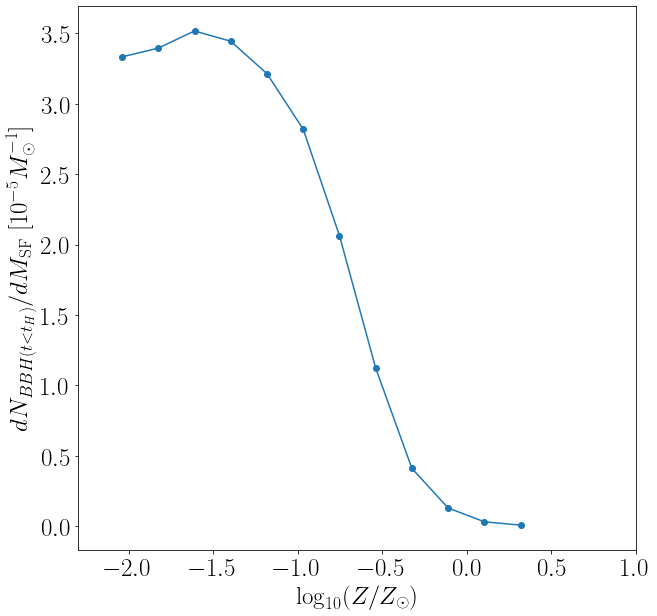

In [120]:
####################
fig, ax = plt.subplots(figsize = (10,10))

Zsun = 0.014 
plt.plot(np.log10(10**center_bins/(Zsun)), N_BBH_tH/(Average_SF_mass_needed*AIS_fraction) *10**5 , marker = 'o')

########
plt.xlabel('$\log_{10}(Z/Z_{\odot})$')
plt.ylabel('$dN_{BBH(t<t_{H})}/dM_{\mathrm{SF} }$ $[10^{-5} M^{-1}_{\odot}]$')
plt.xlim(-2.3, 1.)
plt.show()

# Define our star formation rate w. redshift (SFRD) 

These are exacly the same as COMPAS_sfrd.find_metallicity_distribution(),  but I define it here again to have the complete overview



In [123]:

def Madau_Dickinson2014(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    """
        Calculate the star forming mass per unit volume per year following form of Madau & Dickinson 2014
        Default van son + 2021 : [a = 0.02,  b = 1.48, c =  4.45, d = 5.90] 
        Args:
            redshifts --> [list of floats] List of redshifts at which to evaluate the sfr

        Returns:
            sfr       --> [list of floats] Star forming mass per unit volume per year for each redshift
    """
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value




# Plot the SFR

Using Madau & dickenson 2014 shape

max value 103725053.57949299  at x_max =  11.350524130265518 Gyr
saving here /Users/lieke/surfdrive/Documents/SFRD_effects/plots/SFR_tlookback.pdf


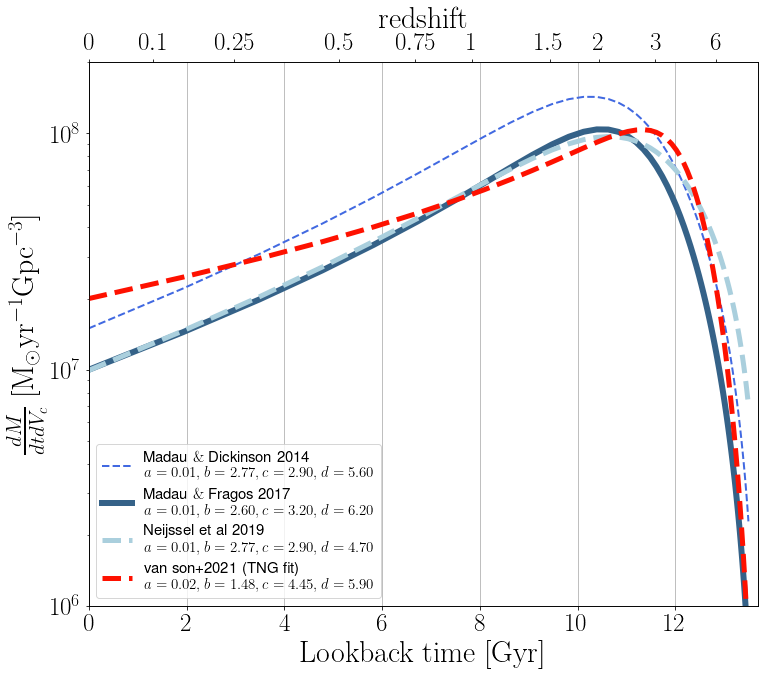

max value 103725053.57949299  at x_max =  2.7272727272727275
saving here /Users/lieke/surfdrive/Documents/SFRD_effects/plots/SFR_redshift.pdf


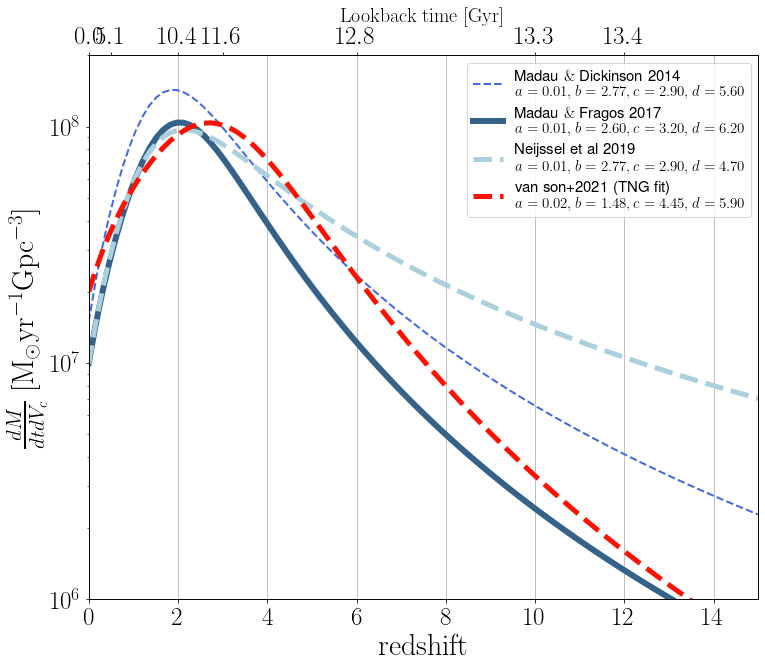

In [132]:

########################################################
# plot different SFRs
########################################################
def plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7):
    ########################################################
    # Start plotting
    fig, ax = plt.subplots(figsize=(12,10))

    if x_redshift:
        x1  = redshift_list
    else:
        x1 = cosmo.lookback_time(redshift_list)

    #default M&D 14
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.015,b=2.77,c=2.9,d=5.6), 
             label = 'Madau $\&$ Dickinson 2014\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.77,2.9,5.6)
             , c = 'royalblue', ls = '--',lw=2)

    #default Madau & Fragos 17
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
             label = 'Madau $\&$ Fragos 2017\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
             , c = '#356288', ls = '-',lw=6)

    #default Coen
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
             label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
             , c = '#aacfdd', lw=5, ls = '--')
    

    # default van son 21 (following TNG)
    y_vals = Madau_Dickinson2014(redshift_list,a = 0.02,  b = 1.48, c =  4.45, d = 5.90)
    ax.plot(x1, y_vals, label = 'van son+2021 (TNG fit)\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.02, 1.48, 4.45, 5.90) , c = '#fe1100', lw=5, ls = '--', zorder =10)
    print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])

    #### Age Universe Axis ####
    ax2 = ax.twiny()

    if x_redshift:
        ###################
        #Plotvalues
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find loockback location for each of our redshifts
        redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    else:
        ###################
        #Plotvalues
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30)


    ##########################################################################
    ax.xaxis.grid(5) # vertical lines
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    logy = True
    if logy:
        plt.yscale('log')
    ax.set_ylabel(r'$\frac{dM}{dt dV_c}$ $\mathrm{[M_{\odot} yr^{-1} Gpc^{-3}]}$', fontsize = 30)
    ax.set_ylim(1e-3*1e9, 0.2 *1e9)
    ax.legend(fontsize = 15)
    if x_redshift:
        print('saving here', save_loc + 'SFR_redshift'+'.pdf')
        plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
    else:
        print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
        plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
    
    plt.show()

    
# Time axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

# redshift axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 15)


# Define our metallicity density distribution (dP/dZ)

These are exacly the same as COMPAS_sfrd.find_metallicity_distribution()



In [131]:
def find_metallicity_distribution(redshifts, min_logZ_COMPAS, max_logZ_COMPAS,
                                  mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):
                                 
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    =  0.035    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.25    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 0.39     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.00     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = 0.00    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """ 
    ##################################
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma) 
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI )  ) 

    ##################################
    # create a range of metallicities (thex-values, or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)


    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, p_draw_metallicity


In [150]:
# Get dPdZ 
z_first_SF    = 10
redshift_step = 0.001
redshifts     = np.arange(0, z_first_SF + redshift_step, redshift_step)
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

min_logZ_COMPAS, max_logZ_COMPAS = np.log(np.min(SYS['Metallicity@ZAMS(1)'])), np.log(np.max(SYS['Metallicity@ZAMS(1)']))

dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(redshifts, min_logZ_COMPAS, max_logZ_COMPAS)
#                                   mu0=0.025, muz=-0.05, sigma_0=1.125, sigma_z=0.05, alpha =-1.77) #van son
#                                   mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0) # Coen
                                                                           
print('max value of dPdlogZ', np.amax(dPdlogZ )/p_draw_metallicity )

max value of dPdlogZ 5.834563220798856


## Plot it

No handles with labels found to put in legend.


saving here /Users/lieke/surfdrive/Documents/SFRD_effects/plots/SFR_tlookback.pdf


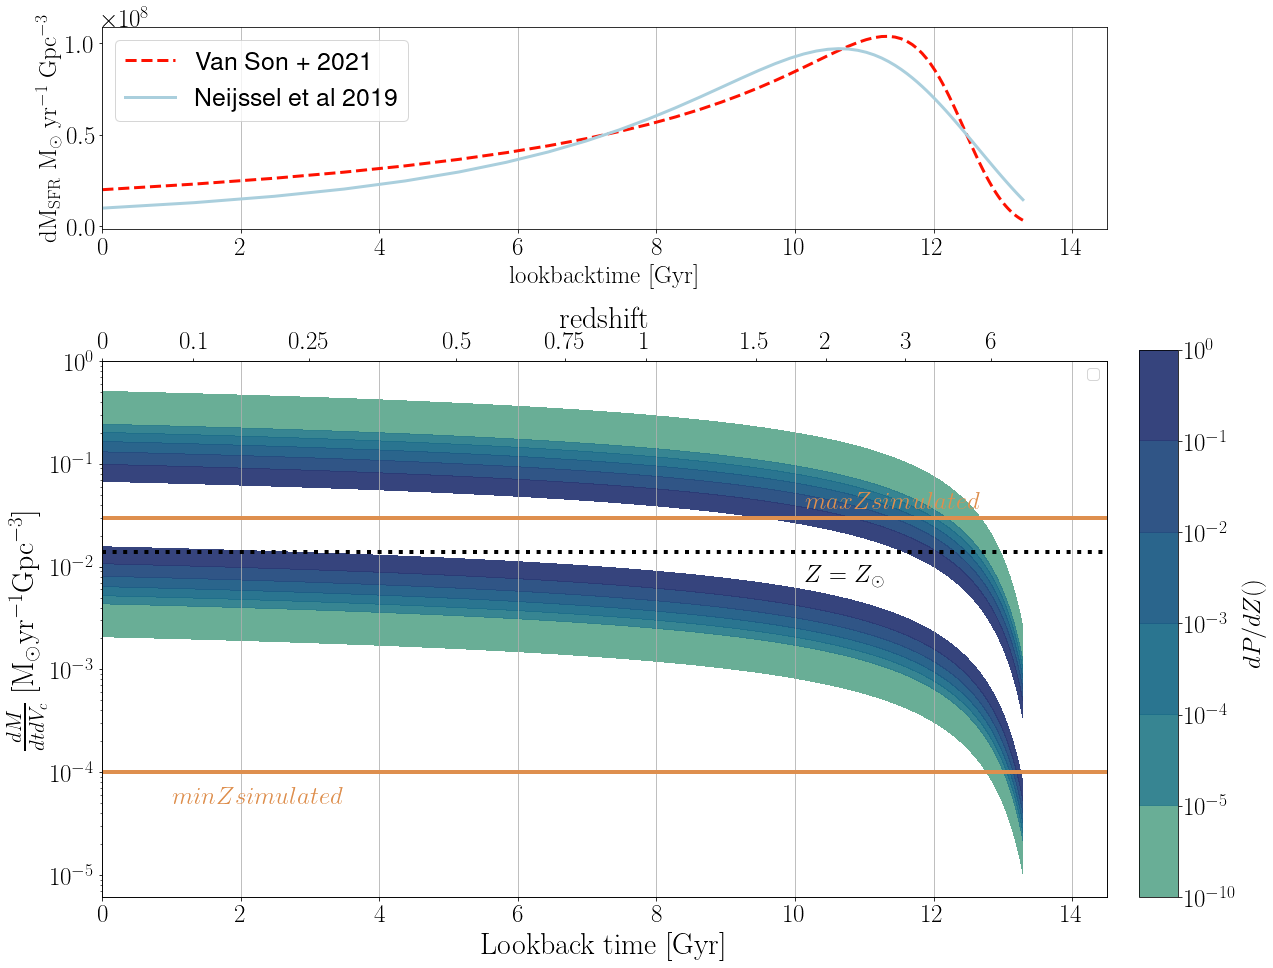

In [153]:

from matplotlib import ticker, cm

def metal_contours(x = None, y = None, z = None, tmin = 0.0, tmax = 14.5,
                   redshift_list = np.linspace(0,10, num=100), x_redshift = False, 
                  kleur = cm.PuBu, kleurlabel = '$\gamma = -0.23$',savestr ='fid',
                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    # Create the Figure
    fig = plt.figure(figsize = (18,16))
    
    # Add a grid
    gs = fig.add_gridspec(nrows=3, ncols=1, hspace=0.65)
    # axis for the SFR
    ax_top = fig.add_subplot(gs[0, :])
    # Axis for the main plot
    ax = fig.add_subplot(gs[1:3, :])

    ##############################################################################
    ######################################
    # Plot SFR 
    if x_redshift:
        x1  = redshift_list
    else:
        x1 = cosmo.lookback_time(redshift_list)
    
    #default Van son
    ax_top.plot(x1, Madau_Dickinson2014(redshift_list, a = 0.02,  b = 1.48, c =  4.45, d = 5.90),
                lw=3, color= '#fe1100', linestyle='--', label = 'Van Son + 2021')

    #default Coen
    ax_top.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7),
                lw=3, color= '#aacfdd', label = 'Neijssel et al 2019')
    ax_top.set_xlabel('$\mathrm{lookbacktime \ [Gyr]}$')

    
    # Plot values
    ax_top.set_xlim(tmin, tmax)
    ax_top.set_ylabel('$\mathrm{dM_{SFR} \ M_{\odot} \ yr^{-1} \ Gpc^{-3}}$')
    ax_top.xaxis.grid(5) # vertical lines
    ax_top.legend()
    
    ##############################################################################
    ######################################
    # Plot the contours of the metallicity density
    levels = [1e-10,1e-5, 1e-4,1e-3, 1e-2, 1e-1,1.]#np.logspace(-4, 0., 10+1)
    
    cs = ax.contourf(x, y, z, levels, cmap=kleur, 
                     locator=ticker.LogLocator(), alpha = 0.95 )
    cbaxes = fig.add_axes([0.925, 0.125, 0.03, 0.475]) #[left, bottom, width, height],
    cb = plt.colorbar(cs, cax = cbaxes, label= kleurlabel)  
    
    kleur = '#de8f4e'#'#f67280' (Used for all COMPAS things)
    ######################################
    ## Show boundaries of COMPAS
    ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
               color = kleur, lw = 4, ls = '-')
    ax.text(1.,np.e**min_logZ_COMPAS - 0.00005, '$min Z simulated$', color = kleur, size =25)

    ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
               color = kleur, lw = 4, ls = '-')
    ax.text(0.7,0.725, '$max Z simulated$', color = kleur,transform=ax.transAxes, size =25)
    
    ## And Zsun
    ax.hlines(0.014, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
               color = 'k', lw = 4, ls = ':')
    ax.text(0.7, 0.62, '$Z=Z_{\odot}$', color = 'k', va='top',transform=ax.transAxes, size =25)
    

    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback time [Gyr]}$')
    ax.set_ylabel('Metallicity')
    
    
    #### Age Universe Axis ####
    ax2 = ax.twiny()

    if x_redshift:
        ###################
        #Plotvalues
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find loockback location for each of our redshifts
        redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    else:
        ###################
        #Plotvalues
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30)
    ##########################################################################
    ax.xaxis.grid(5) # vertical lines
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    logy = True
    if logy:
        plt.yscale('log')
    ax.set_ylabel(r'$\frac{dM}{dt dV_c}$ $\mathrm{[M_{\odot} yr^{-1} Gpc^{-3}]}$', fontsize = 30)
    ax.legend(fontsize = 15)
    if x_redshift:
        print('saving here', save_loc + 'SFR_redshift'+'.pdf')
        plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
    else:
        print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
        plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
    
    
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()

    
color_pallette = sns.color_palette("crest", as_cmap=True)


# Plot it!
metal_contours(x = t_lookback, y = metallicities, z =dPdlogZ.T/p_draw_metallicity, savestr ='0.15', 
               kleur = color_pallette, kleurlabel ='$dP/dZ()$' )
                                                                           
                                                                           
                                                                           

No handles with labels found to put in legend.


saving here /Users/lieke/surfdrive/Documents/SFRD_effects/plots/SFR_redshift.pdf


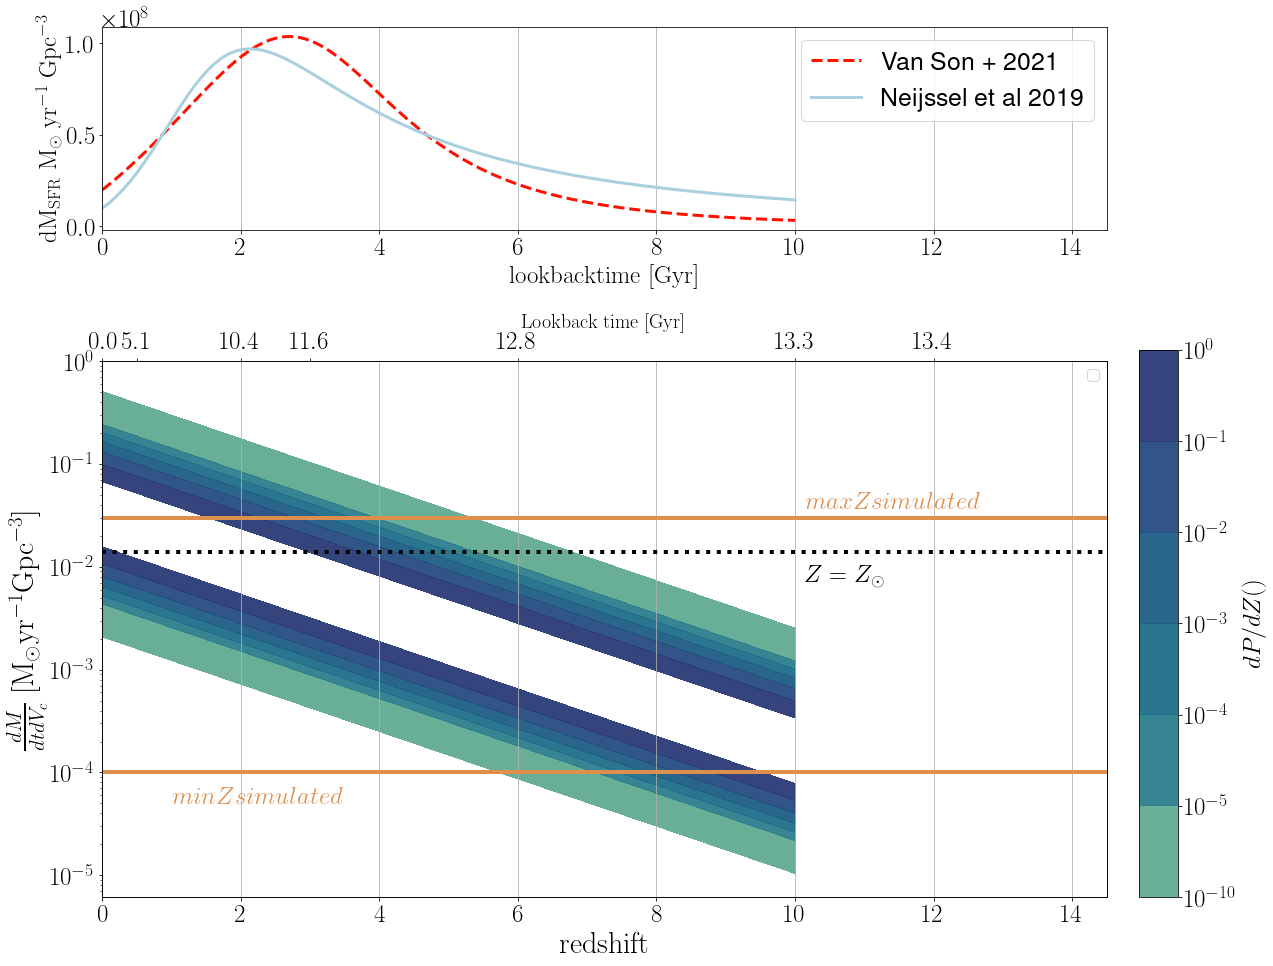

In [154]:
# Plot it!
metal_contours(x = redshifts, y = metallicities, z =dPdlogZ.T/p_draw_metallicity, x_redshift = True, 
               kleur = color_pallette, kleurlabel ='$dP/dZ()$' )
                                                                       